In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import datetime
from datetime import date, timedelta

In [2]:
(date.today() - timedelta(days=1095)).strftime("%Y-%m-%d")


'2021-01-10'

In [3]:
date.today().strftime("%Y-%m-%d")

'2024-01-10'

Dataset Loaded! Length of the data = 742


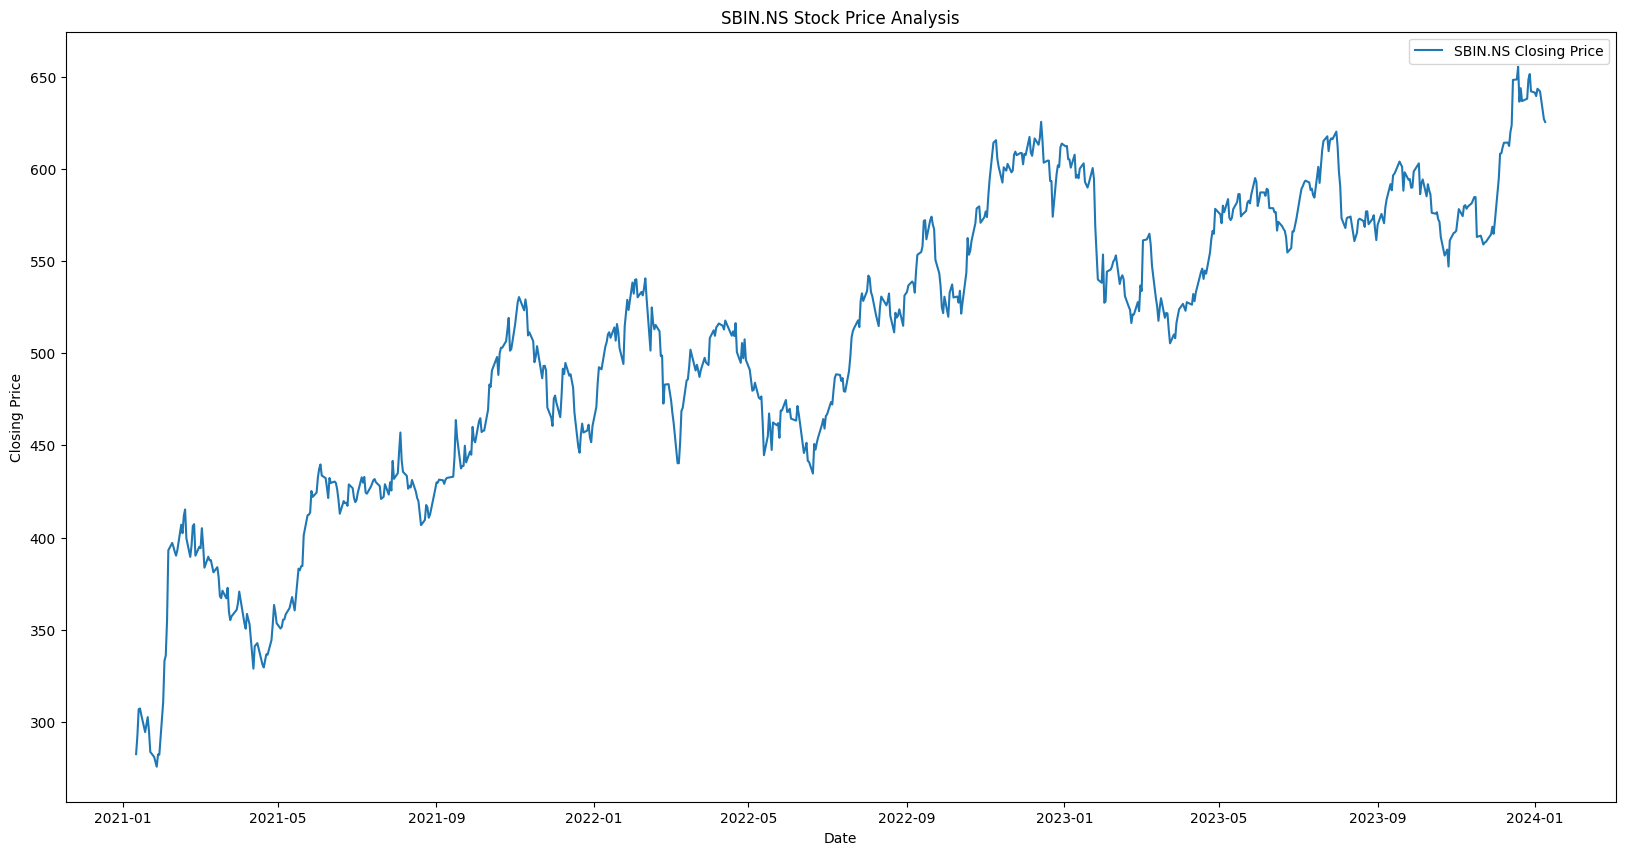

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 100, 100)          40800     
                                                                 
 lstm_31 (LSTM)              (None, 100)               80400     
                                                                 
 dense_15 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
7/7 [==============================] - 8s 451ms/step - loss: 0.1052 - val_loss: 0.0031
Epoch 2/10
7/7 [==============================] - 2s 300ms/step - loss: 0.0141 - val_loss: 0.0250
Epoch 3/10
7/7 [==============================] - 2s 296ms/step - loss: 0.0058 - val_loss: 0.0045
Epoch 4/10
7/7 [=

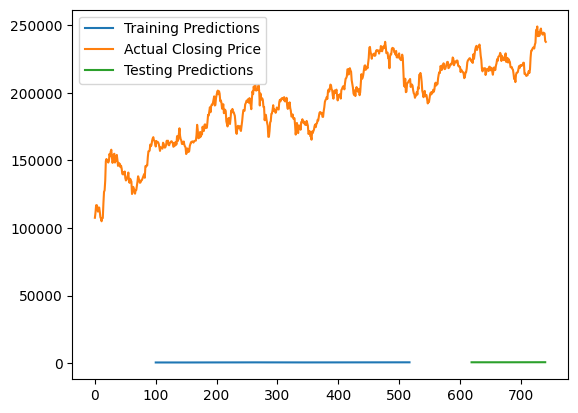

Forecasted Data
[[435.98178]
 [437.5545 ]
 [438.95193]
 [440.06564]
 [440.97504]
 [441.67722]
 [442.07062]
 [442.01453]
 [441.36798]
 [440.6342 ]
 [439.833  ]
 [439.03464]
 [438.21082]
 [437.87595]
 [437.80222]
 [437.69742]
 [437.4842 ]
 [437.25528]
 [437.18573]
 [437.55698]
 [438.0895 ]
 [438.8305 ]
 [439.33853]
 [439.63846]
 [439.93246]
 [440.27435]
 [440.71115]
 [441.21805]
 [441.6807 ]
 [442.00864]
 [441.94992]
 [441.6816 ]
 [441.56024]
 [441.318  ]
 [441.2751 ]
 [441.18887]
 [441.7242 ]
 [442.25885]
 [442.89487]
 [444.03494]
 [445.87927]
 [447.5037 ]
 [448.65793]
 [449.3522 ]
 [449.4258 ]
 [449.14508]
 [448.60403]
 [448.0781 ]
 [447.33295]
 [446.34348]
 [445.16498]
 [443.39215]
 [441.4168 ]
 [439.7212 ]
 [438.23645]
 [436.7413 ]
 [435.3765 ]
 [434.57236]
 [434.31415]
 [434.58792]
 [435.1983 ]
 [436.07074]
 [437.06183]
 [438.00592]
 [438.9633 ]
 [439.92157]
 [440.85742]
 [441.7407 ]
 [442.98425]
 [445.20944]
 [447.605  ]
 [449.33762]
 [450.60123]
 [451.49283]
 [452.5345 ]
 [453.265

In [26]:
class Stock():
    def __init__(self, stk_name, start_date=(date.today() - timedelta(days=1095)).strftime("%Y-%m-%d"), end_date=(date.today()).strftime("%Y-%m-%d"), time_steps=100):
        self.symbol = stk_name
        self.start_date = start_date
        self.end_date = end_date
        self.data = self.load()
        self.train_data = None
        self.trainX = None
        self.trainY = None
        self.test_data = None
        self.testX = None
        self.testY = None
        self.window_size = time_steps
        self.scaler = MinMaxScaler()

    def load(self):
        df = yf.download(self.symbol, start=self.start_date, end=self.end_date, progress=False)
        print(f"Dataset Loaded! Length of the data = {len(df)}")
        return df

    def plot_stock_data(self):
        plt.figure(figsize=(20, 10))
        plt.plot(self.data["Close"], label=f"{self.symbol} Closing Price")
        plt.title(f'{self.symbol} Stock Price Analysis')
        plt.xlabel('Date')
        plt.ylabel('Closing Price')
        plt.legend()
        plt.show()
    
    def preprocess_data(self):
        closing_prices = self.data["Close"].values.reshape(-1, 1)
        closing_prices_scaled = self.scaler.fit_transform(closing_prices)
        
        training_size = int(0.7 * len(closing_prices_scaled))
        train_data, test_data = closing_prices_scaled[:training_size], closing_prices_scaled[training_size:]
        
        self.train_data, self.test_data = train_data, test_data

        
    def create_dataset(self, dataset, time_step=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-time_step-1):
            a = dataset[i:(i+time_step), 0]
            dataX.append(a)
            dataY.append(dataset[i+time_step, 0])
        return np.array(dataX), np.array(dataY)
    
    def LSTMModelcreation(self, units=100):
        self.trainX, self.trainY = self.create_dataset(self.train_data, time_step=self.window_size)
        self.testX, self.testY = self.create_dataset(self.test_data, time_step=self.window_size)

        self.trainX = np.reshape(self.trainX, (self.trainX.shape[0], self.trainX.shape[1], 1))
        self.testX = np.reshape(self.testX, (self.testX.shape[0], self.testX.shape[1], 1))

        model = Sequential()
        model.add(LSTM(units=units, return_sequences=True, input_shape=(self.window_size, 1)))
        model.add(LSTM(units=units))
        model.add(Dense(units=1))
        model.compile(optimizer="adam", loss="mean_squared_error")
        model.summary()

        return model
    
    def fit(self, model):
        model.fit(self.trainX, self.trainY, validation_data=(self.testX, self.testY), epochs=10, batch_size=64, verbose=1)
        
    def forecast(self, model):
        train_predict = model.predict(self.trainX)
        test_predict = model.predict(self.testX) 
        train_predict = self.scaler.inverse_transform(train_predict.reshape(-1, 1))
        test_predict = self.scaler.inverse_transform(test_predict.reshape(-1, 1))

        # Creating empty arrays for plotting
        trainPredictPlot = np.empty_like(self.data[["Close"]])
        trainPredictPlot[:,:] = np.nan
        trainPredictPlot[self.window_size:len(train_predict)+self.window_size, :] = train_predict

        testPredictPlot = np.empty_like(self.data[["Close"]])
        testPredictPlot[:, :] = np.nan
        testPredictPlot[len(train_predict)+(self.window_size*2)+1:len(self.data)-1, :] = test_predict

        import math
        from sklearn.metrics import mean_squared_error
        # Plotting
        plt.plot(trainPredictPlot[:], label='Training Predictions')
        plt.plot(self.scaler.inverse_transform(self.data[["Close"]]), label='Actual Closing Price')
        plt.plot(testPredictPlot, label='Testing Predictions')
        plt.legend()
        plt.show()

        # Return forecasted data
        return np.concatenate([train_predict, test_predict], axis=0)
    
# Example usage
a = Stock("SBIN.NS")
a.plot_stock_data()
a.preprocess_data()
model = a.LSTMModelcreation()
a.fit(model)
data_tra = a.forecast(model)
print("Forecasted Data")
print(data_tra)


In [27]:
print("Number of data points:", len(data_tra))


Number of data points: 540


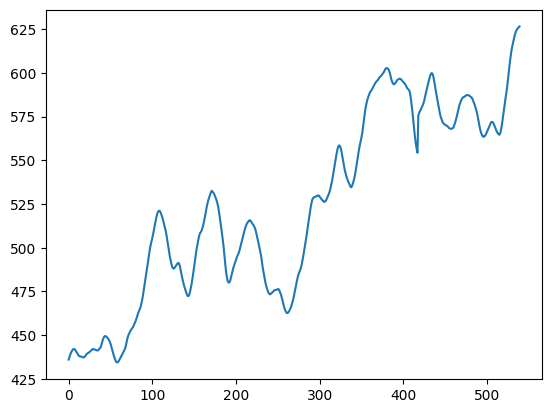

In [28]:
plt.plot(data_tra)